# Water Table Analysis
Author: Ian Coleman <br>
Purpose: Analyse water table data

In [178]:
import pandas as pd
import numpy as np
import scipy as sp
import subprocess
import math
import seaborn as sb
import pdb
from correlade import correlade # I wrote this --> I'm cool
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

### Import Data

In [79]:
wt = pd.read_csv("data.csv")

/home/ian/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [80]:
## TODO
# Strip all cols
# Drop NA
# Address unknowns and similar
# force int cols to int type etc
# break col types further into uint, int16, int8 etc
# force uints to be uints BEWARE of conversion as methods like astype can mislead
# Expand beyond dataset - any available complimentary data?
# Remove unwanted cols like cats pre encoding and recorded_by_encoded
# Graph the datetime var
# Normalisation stuff. Particularly for construction year

In [81]:
# Iterate through columns, assign each a data type
# NB the output will need to be checked by some common sense  

cat_cols = []
int_cols = []
float_cols = []
bool_cols = []
undetermined = []

for col in wt.columns:
    clean_col = wt[col].replace(0, np.nan)
    clean_col = wt[col].replace(0.0, np.nan)
    clean_col = wt[col].dropna()
    mode_val = str(clean_col.mode().values[0]).lower()
    
    if mode_val == 'true' or mode_val == 'false':
        bool_cols.append(col)
    elif isinstance(clean_col.mode().values[0], float):
        float_cols.append(col)
    elif mode_val.isnumeric():
        int_cols.append(col)
    elif (len(clean_col.unique()) < 100):
        cat_cols.append(col)
    else:
        undetermined.append(col)
        
        
print("\n int_cols --  \n", int_cols)
print("\n float_cols --  \n", float_cols)
print("\n cat_cols --  \n", cat_cols)
print("\n bool_cols --  \n", bool_cols)
print("\n undetermined --  \n", undetermined)


 int_cols --  
 ['id', 'num_private', 'region_code', 'district_code', 'population', 'construction_year']

 float_cols --  
 ['amount_tsh', 'gps_height', 'longitude', 'latitude']

 cat_cols --  
 ['basin', 'region', 'recorded_by', 'scheme_management', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']

 bool_cols --  
 ['public_meeting', 'permit']

 undetermined --  
 ['date_recorded', 'funder', 'installer', 'wpt_name', 'subvillage', 'lga', 'ward', 'scheme_name']


In [82]:
# Set and check date type cols
print(wt["date_recorded"][0])
print(pd.to_datetime(wt["date_recorded"])[0])

3/14/11
2011-03-14 00:00:00


In [83]:
cat_cols = {key: "category" for key in cat_cols}
int_cols = {key: "int" for key in int_cols}
float_cols = {key: "float" for key in float_cols}
bool_cols = {key: "bool" for key in bool_cols} 
undetermined = {key: "object" for key in undetermined}
col_types = {**cat_cols, **int_cols, **float_cols, **bool_cols}

In [84]:
# # Enter the manual changes to programmatically assigned dtypes
col_types['date_recorded'] = 'datetime64'
col_types['region_code'] = 'category'
col_types['district_code'] = 'category'
# del col_types['date_recorded']

In [85]:
col_types

{'basin': 'category',
 'region': 'category',
 'recorded_by': 'category',
 'scheme_management': 'category',
 'extraction_type': 'category',
 'extraction_type_group': 'category',
 'extraction_type_class': 'category',
 'management': 'category',
 'management_group': 'category',
 'payment': 'category',
 'payment_type': 'category',
 'water_quality': 'category',
 'quality_group': 'category',
 'quantity': 'category',
 'quantity_group': 'category',
 'source': 'category',
 'source_type': 'category',
 'source_class': 'category',
 'waterpoint_type': 'category',
 'waterpoint_type_group': 'category',
 'id': 'int',
 'num_private': 'int',
 'region_code': 'category',
 'district_code': 'category',
 'population': 'int',
 'construction_year': 'int',
 'amount_tsh': 'float',
 'gps_height': 'float',
 'longitude': 'float',
 'latitude': 'float',
 'public_meeting': 'bool',
 'permit': 'bool',
 'date_recorded': 'datetime64'}

In [86]:
## Assign the data types, ignoring errors
for col in col_types:
    wt[col] = wt[col].astype(col_types[col], errors='ignore')

In [87]:
# In this cell I sweep through possible errors using astype conversion without ignoring errors, 
# Then I patch each error and rerun until it runs through. Handy way to catch edge cases of problematic data
# This won't catch everything e.g Typos -> should run value_counts on all categoricals to test for this   
for col in float_cols:
    wt[col] = wt[col].apply(lambda x: x if isinstance(x, float) else np.nan)

for col in int_cols:
    wt[col] = wt[col].apply(lambda x: x if isinstance(x, int) else np.nan)
    wt[col] = wt[col].replace([np.inf, -np.inf], np.nan)
#     wt[col] = wt[col].replace(np.nan, 0) ->

for col in col_types:
    wt[col] = wt[col].astype(col_types[col])

In [88]:
# I visually glance through random rows for unpredicted systematic and random errors (run this cell * ~3)
wt.sample(10)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
7553,61738,0.0,2011-03-09,Magoma Adp,341.0,Local technician,38.584448,-4.902729,Sekondari,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
21538,29435,NaN,2011-03-26,NaN,0.0,NaN,33.094444,-9.316716,Kwa Mgaya,0,...,unknown,soft,good,seasonal,seasonal,shallow well,shallow well,groundwater,hand pump,hand pump
10477,48496,5000.0,2013-01-27,World Bank,758.0,Distri,30.403643,-6.741419,Stendi,0,...,annually,soft,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe
4507,66248,0.0,2011-07-30,Redep,0.0,DWE,33.081339,-2.413709,Kwa Elikana,0,...,never pay,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
34642,54011,NaN,2013-02-03,World Bank,1646.0,World Bank,29.816752,-4.460543,Kwa Gituli,0,...,never pay,soft,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe
33706,7481,NaN,2013-03-23,Cipro/government,631.0,CIPRO/Government,37.918670,-4.515275,Kwa Mbonea,0,...,monthly,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
17084,22185,NaN,2013-02-05,Ministry Of Water,412.0,Regional Water,39.320805,-10.618834,Madukani,0,...,never pay,soft,good,enough,enough,spring,spring,groundwater,other,other
47260,69439,NaN,2011-02-23,Twe,1963.0,TWE,34.705860,-9.659366,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
42629,18991,NaN,2011-08-09,Tasaf,0.0,TASAF,33.125649,-2.620488,Kwa Shil,0,...,never pay,unknown,unknown,unknown,unknown,machine dbh,borehole,groundwater,hand pump,hand pump
28745,20647,NaN,2011-03-23,Danida,6.0,DA,38.891802,-6.521369,Kwa Patel,0,...,per bucket,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe


In [89]:
wt.dtypes

id                                int64
amount_tsh                      float64
date_recorded            datetime64[ns]
funder                           object
gps_height                      float64
installer                        object
longitude                       float64
latitude                        float64
wpt_name                         object
num_private                       int64
basin                          category
subvillage                       object
region                         category
region_code                    category
district_code                  category
lga                              object
ward                             object
population                        int64
public_meeting                     bool
recorded_by                    category
scheme_management              category
scheme_name                      object
permit                             bool
construction_year                 int64
extraction_type                category


In [90]:
# Import outcome csv
labels = pd.read_csv("labels.csv")
print('Shape: ', labels.shape)

Shape:  (59400, 2)


In [91]:
labels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [92]:
# assign types and account for errors in outcome csv
labels['id'] = labels['id'].replace(to_replace ='[!]', value = np.nan, regex = True) # aimed at specific error
labels['id'].dropna(inplace=True)
labels['id'] = labels['id'].astype(int)
labels['status_group'] = labels['status_group'].astype('category')

# Add these cols to the col type storage
cat_cols['status_group'] = 'category'

In [93]:
# Merge the two csvs
print("wt shape: ", wt.shape)
print("labels shape: ", labels.shape)

wt = wt.merge(labels, on='id', how='left')
print("wt shape post merge: ", wt.shape)

wt shape:  (59401, 40)
labels shape:  (59400, 2)
wt shape post merge:  (59402, 41)


In [94]:
wt.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390.0,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399.0,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686.0,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263.0,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0.0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [95]:
# encode categoricals
for col in cat_cols:
    new_name = col + '_encoded'
    wt[new_name] = wt[col].cat.codes

In [96]:
# encode booleans
for col in bool_cols:
    new_name = col + '_encoded'
    wt[new_name] = wt[col].apply(lambda x: 0 if x is False else 1)
    wt[new_name] = wt[new_name].astype(np.int8)
    
# checking it worked
# wt[['public_meeting_encoded', 'permit_encoded', 'permit', 'public_meeting']]

### Exploratory Analysis

In [97]:
wt.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,quantity_encoded,quantity_group_encoded,source_encoded,source_type_encoded,source_class_encoded,waterpoint_type_encoded,waterpoint_type_group_encoded,status_group_encoded,public_meeting_encoded,permit_encoded
0,69572,6000.0,2011-03-14,Roman,1390.0,Roman,34.938093,-9.856322,none,0,...,1,1,8,7,0,1,1,0,1,0
1,8776,0.0,2013-03-06,Grumeti,1399.0,GRUMETI,34.698766,-2.147466,Zahanati,0,...,2,2,5,4,1,1,1,0,1,1
2,34310,25.0,2013-02-25,Lottery Club,686.0,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,1,1,0,1,1,2,1,0,1,1
3,67743,0.0,2013-01-28,Unicef,263.0,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,0,0,3,0,0,2,1,2,1,1
4,19728,0.0,2011-07-13,Action In A,0.0,Artisan,31.130847,-1.825359,Shuleni,0,...,3,3,5,4,1,1,1,0,1,1


In [98]:
wt.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,population,construction_year,basin_encoded,region_encoded,...,quantity_encoded,quantity_group_encoded,source_encoded,source_type_encoded,source_class_encoded,waterpoint_type_encoded,waterpoint_type_group_encoded,status_group_encoded,public_meeting_encoded,permit_encoded
count,59402.000000,26634.000000,59401.000000,59402.000000,5.940200e+04,59402.000000,59402.000000,59402.000000,59402.000000,59402.000000,...,59402.000000,59402.000000,59402.000000,59402.000000,59402.000000,59402.000000,59402.000000,59402.000000,59402.000000,59402.000000
mean,37115.198209,328.704545,668.299069,34.077513,-5.706111e+00,0.474125,179.902007,1300.675381,4.538366,9.835881,...,1.325747,1.325747,6.063230,4.758325,0.233746,2.574038,2.056177,0.841100,0.914902,0.705515
std,21453.555072,3284.004629,693.107111,6.567348,2.946057e+00,12.236024,471.476973,951.612717,2.896848,5.936992,...,0.803760,0.803760,2.034171,2.575695,0.434134,1.781431,1.378928,0.949874,0.279030,0.455815
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,-200.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000
25%,18519.250000,0.000000,0.000000,33.090410,-8.540946e+00,0.000000,0.000000,0.000000,2.000000,4.000000,...,1.000000,1.000000,5.000000,4.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,25.000000,1986.000000,4.000000,10.000000,...,1.000000,1.000000,7.000000,6.000000,0.000000,2.000000,1.000000,0.000000,1.000000,1.000000
75%,55657.500000,20.000000,1319.000000,37.178460,-3.326168e+00,0.000000,214.750000,2004.000000,7.000000,15.000000,...,2.000000,2.000000,8.000000,7.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,30500.000000,2013.000000,9.000000,20.000000,...,4.000000,4.000000,9.000000,7.000000,2.000000,6.000000,5.000000,3.000000,1.000000,1.000000


In [99]:
wt.dtypes

id                                        int64
amount_tsh                              float64
date_recorded                    datetime64[ns]
funder                                   object
gps_height                              float64
                                      ...      
waterpoint_type_encoded                    int8
waterpoint_type_group_encoded              int8
status_group_encoded                       int8
public_meeting_encoded                     int8
permit_encoded                             int8
Length: 64, dtype: object

In [180]:
print(wt.isna().sum())

id                                   0
amount_tsh                       51527
date_recorded                        0
funder                            3635
gps_height                           2
installer                         3655
longitude                         1812
latitude                             0
num_private                      58876
subvillage                         371
region_code                          0
district_code                        0
lga                                  0
ward                                 0
population                       22110
scheme_name                      28165
construction_year                20709
basin_encoded                        0
region_encoded                       0
recorded_by_encoded                  0
scheme_management_encoded            0
extraction_type_encoded              0
extraction_type_group_encoded        0
extraction_type_class_encoded        0
management_encoded                   0
management_group_encoded 

In [101]:
## list the numeric cols

# Note that I'm leaving out int8 - ensure that only categorical encoded cols are int8
numerics = wt.select_dtypes(include=['int', 'int16', 'int32', 'int64', 'float', 'float32', 
                                     'float64']).columns
numerics = list(numerics)
numerics.remove('id')

# numerics = ['gps_height', 'amount_tsh', 'status_group_encoded']\

# sanity check
numerics

['amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'num_private',
 'population',
 'construction_year']

In [102]:
# list the categorical cols

categorics = wt.select_dtypes(include=['int8']).columns
categorics = list(categorics)

# sanity check
categorics

['basin_encoded',
 'region_encoded',
 'recorded_by_encoded',
 'scheme_management_encoded',
 'extraction_type_encoded',
 'extraction_type_group_encoded',
 'extraction_type_class_encoded',
 'management_encoded',
 'management_group_encoded',
 'payment_encoded',
 'payment_type_encoded',
 'water_quality_encoded',
 'quality_group_encoded',
 'quantity_encoded',
 'quantity_group_encoded',
 'source_encoded',
 'source_type_encoded',
 'source_class_encoded',
 'waterpoint_type_encoded',
 'waterpoint_type_group_encoded',
 'status_group_encoded',
 'public_meeting_encoded',
 'permit_encoded']

In [103]:
#### Here I'm going to replace outliers (beyond 3 std devs) - actually removing them!
print(wt.shape)
for col in wt[numerics].columns:
    wt[col] = wt[np.abs(wt[col]-wt[col].mean()) <= (3 * wt[col].std())][col]
#     mean = wt[col].mean()
#     wt[col] = wt[col].fillna(mean)
print(wt.shape)

(59402, 64)
(59402, 64)


In [105]:
## remove zeros from numerics, for nan's
# After plotting distributions below, I see that many are skewed
# It looks like there are a lot of zeros and it's clear (from e.g construction year) that these zeros
# don't represent actual zeros, but must mean missing data
wt['construction_year'] = wt.construction_year.replace(0,np.nan)
wt['amount_tsh'] = wt.amount_tsh.replace(0,np.nan)
wt['population'] = wt.population.replace(0,np.nan)
wt['num_private'] = wt.num_private.replace(0,np.nan)
wt['construction_year'] = wt.construction_year.replace(0.0,np.nan)
wt['amount_tsh'] = wt.amount_tsh.replace(0.0,np.nan)
wt['population'] = wt.population.replace(0.0,np.nan)
wt['num_private'] = wt.num_private.replace(0.0,np.nan)

In [106]:
wt.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,population,construction_year,basin_encoded,region_encoded,...,quantity_encoded,quantity_group_encoded,source_encoded,source_type_encoded,source_class_encoded,waterpoint_type_encoded,waterpoint_type_group_encoded,status_group_encoded,public_meeting_encoded,permit_encoded
count,59402.000000,7874.000000,59400.000000,57590.000000,5.940200e+04,523.000000,37292.000000,38693.000000,59402.000000,59402.000000,...,59402.000000,59402.000000,59402.000000,59402.000000,59402.000000,59402.000000,59402.000000,59402.000000,59402.000000,59402.000000
mean,37115.198209,759.641459,668.263687,35.149721,-5.706111e+00,10.388145,222.991070,1996.813868,4.538366,9.835881,...,1.325747,1.325747,6.063230,4.758325,0.233746,2.574038,2.056177,0.841100,0.914902,0.705515
std,21453.555072,1379.102531,693.059297,2.607422,2.946057e+00,9.553259,258.796663,12.472409,2.896848,5.936992,...,0.803760,0.803760,2.034171,2.575695,0.434134,1.781431,1.378928,0.949874,0.279030,0.455815
min,0.000000,0.200000,-90.000000,29.607122,-1.164944e+01,1.000000,-200.000000,1960.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000
25%,18519.250000,50.000000,0.000000,33.285153,-8.540946e+00,4.000000,35.000000,1987.000000,2.000000,4.000000,...,1.000000,1.000000,5.000000,4.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000
50%,37061.500000,250.000000,369.000000,35.005943,-5.021597e+00,6.000000,150.000000,2000.000000,4.000000,10.000000,...,1.000000,1.000000,7.000000,6.000000,0.000000,2.000000,1.000000,0.000000,1.000000,1.000000
75%,55657.500000,600.000000,1319.000000,37.233742,-3.326168e+00,15.000000,300.000000,2008.000000,7.000000,15.000000,...,2.000000,2.000000,8.000000,7.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000
max,74247.000000,10000.000000,2628.000000,40.345193,-2.000000e-08,35.000000,1590.000000,2013.000000,9.000000,20.000000,...,4.000000,4.000000,9.000000,7.000000,2.000000,6.000000,5.000000,3.000000,1.000000,1.000000


In [107]:
# Standardise all numerics
# Some of the distributions are skewed but they're close enough for standarisation

standardise = lambda x: (x-x.mean()) / x.std()

wt[numerics] = wt[numerics].pipe(standardise)

In [108]:
wt.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,quantity_encoded,quantity_group_encoded,source_encoded,source_type_encoded,source_class_encoded,waterpoint_type_encoded,waterpoint_type_group_encoded,status_group_encoded,public_meeting_encoded,permit_encoded
0,69572,3.799832,2011-03-14,Roman,1.041377,Roman,-0.081164,-1.408734,none,NaN,...,1,1,8,7,0,1,1,0,1,0
1,8776,NaN,2013-03-06,Grumeti,1.054363,GRUMETI,-0.172951,1.207935,Zahanati,NaN,...,2,2,5,4,1,1,1,0,1,1
2,34310,-0.532695,2013-02-25,Lottery Club,0.025591,World vision,0.886294,0.639765,Kwa Mahundi,NaN,...,1,1,0,1,1,2,1,0,1,1
3,67743,NaN,2013-01-28,Unicef,-0.584746,UNICEF,1.279593,-1.849654,Zahanati Ya Nanyumbu,NaN,...,0,0,3,0,0,2,1,2,1,1
4,19728,NaN,2011-07-13,Action In A,-0.964223,Artisan,-1.541321,1.317270,Shuleni,NaN,...,3,3,5,4,1,1,1,0,1,1


In [109]:
# print(wt.shape)
# wt.dropna(inplace=True)
# print(wt.shape)

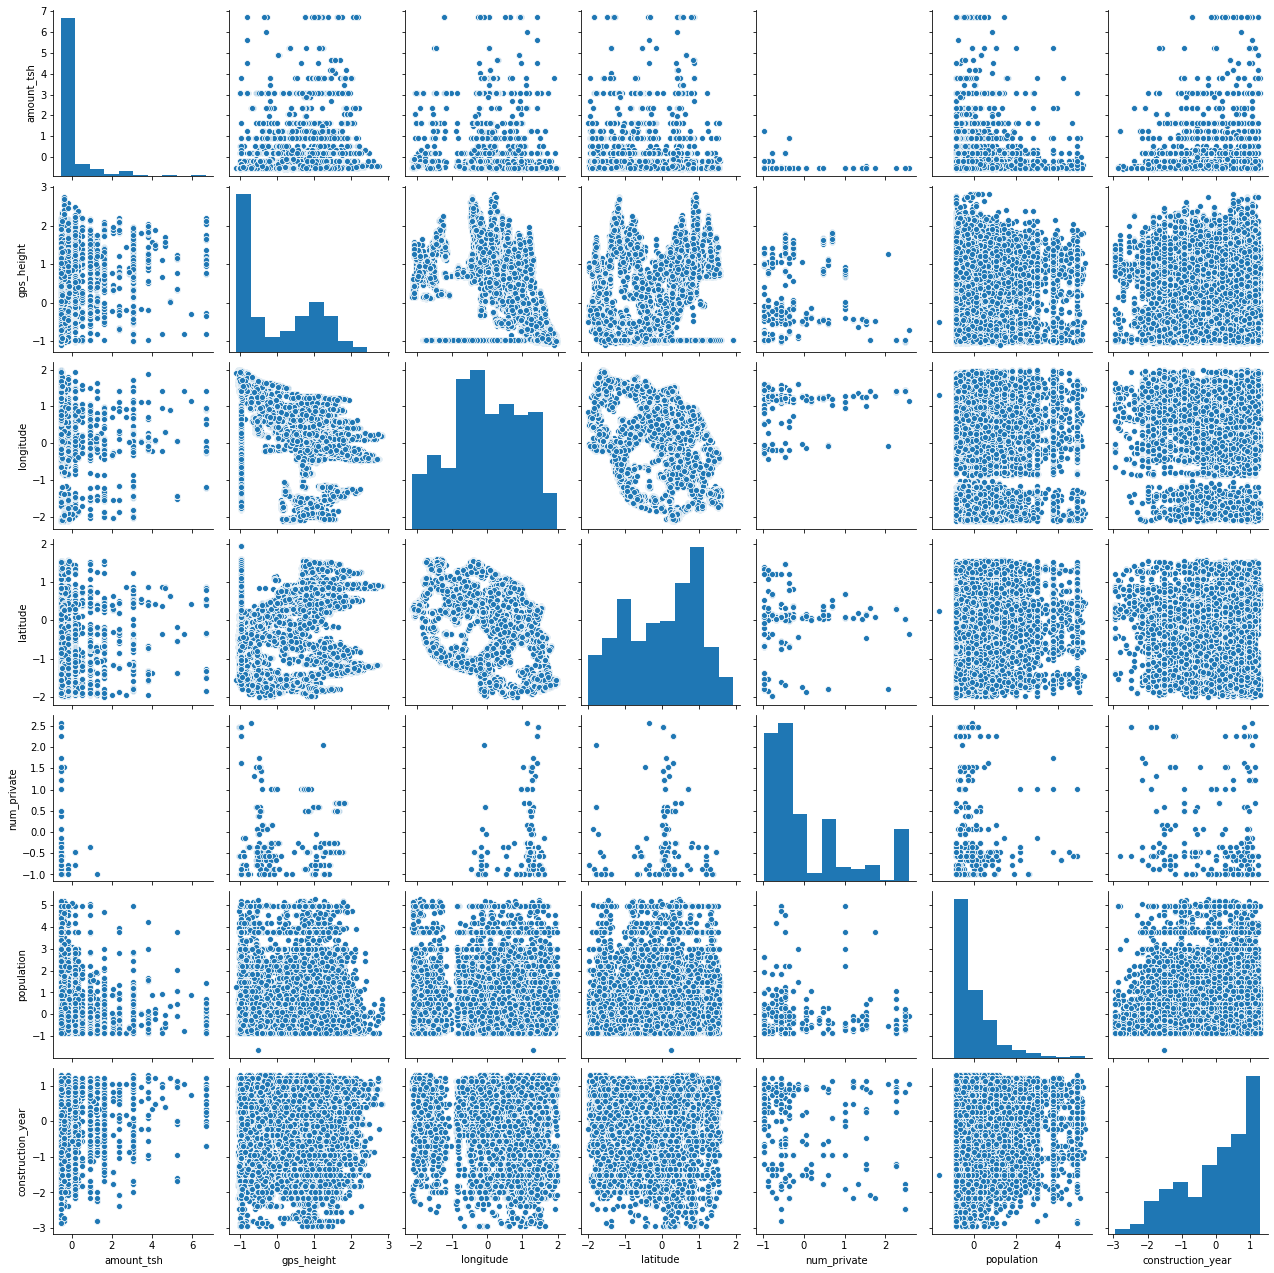

In [110]:
## Continuous vs Continuous

# Pairwise scatterplot --> visually assess for independence of features and for outliers
# More of a sanity check than anything
# This and following cells will see if numeric vars are correlated
# If so they could throw off our models, breaking the common assumption of independence
sb.pairplot(wt[numerics])

# Interpretation:
# 1. remove 0's from construction year (why didn't these get caught by cleaning std dev check? -> too many of them
# 2. gps height, lat and long seem to show some relationship
# 3. Lat, Long and Construction yr should pass as normal dist but
# 4. amount_tsh, gps_height, num_private and population look skewed 
# NB I've now removed zeros 

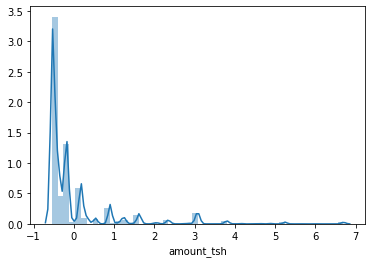

In [111]:
# Zoom in to check if it's really skewed -> maybe I should delete 0's here too 
sb.distplot(wt.amount_tsh[wt.amount_tsh.apply(lambda x: x < 100)]);

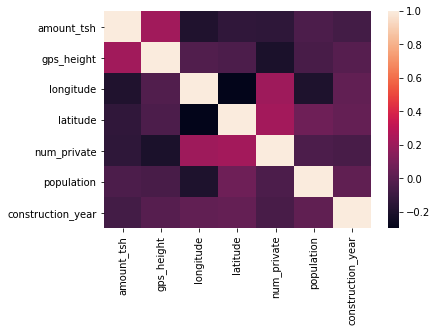

In [112]:
sb.heatmap(wt[numerics].corr()) 
# interpretation:
# amount_tsh and gps_height might have a mild correlation
# population and gps_height also
# though remember amount and pop had skewed dist - see next cell

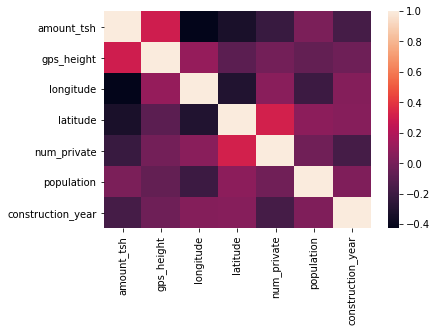

In [113]:
sb.heatmap(wt[numerics].corr(method='spearman')) 
# interpretation
# 1. Correlation between pop and gps_height
# 2. 

In [114]:
wt[numerics].corr(method='spearman')

,amount_tsh,gps_height,longitude,latitude,num_private,population,construction_year
amount_tsh,1.000000,0.298439,-0.427543,-0.330186,-0.214993,0.020347,-0.166025
gps_height,0.298439,1.000000,0.104601,-0.087444,-0.007950,-0.062842,-0.021367
longitude,-0.427543,0.104601,1.000000,-0.299702,0.063931,-0.202977,0.051434
latitude,-0.330186,-0.087444,-0.299702,1.000000,0.314668,0.075677,0.053893
num_private,-0.214993,-0.007950,0.063931,0.314668,1.000000,-0.019831,-0.166187
population,0.020347,-0.062842,-0.202977,0.075677,-0.019831,1.000000,0.031331
construction_year,-0.166025,-0.021367,0.051434,0.053893,-0.166187,0.031331,1.000000


In [146]:
# Drop NA, except for num_private which is mostly NA
wt_dropna_except_numprivate = wt.dropna(subset=['amount_tsh', 'gps_height', 
                                                                'longitude', 'population', 
                                                                'construction_year'])

# wt_dropna_except_numprivate = wt_dropna_except_numprivate.drop(columns=['num_private'])
wt_dropna_except_numprivate.shape

(7196, 64)

In [137]:
# Get pairwise Distance Covariance 
# NB I made this pip library myself
# Distance correlation is more robust than pearson, ken, spear - Székely, Rizzo and Bakirov (2007) and Lyons (2013)
# less dependent on linear relationship. 0 actually does imply independence
correlade.dcorr(wt_dropna_except_numprivate[numerics])
# Conclusions: 
# gps_height correlates with lat and long


                  amount_tsh gps_height longitude  latitude num_private  \
amount_tsh                 1      0.255  0.328432  0.202141         NaN   
gps_height             0.255          1   0.67867  0.358937         NaN   
longitude           0.328432    0.67867         1  0.277665         NaN   
latitude            0.202141   0.358937  0.277665         1         NaN   
num_private              NaN        NaN       NaN       NaN         NaN   
population         0.0363213  0.0938919  0.293382  0.128825         NaN   
construction_year   0.186134    0.11273  0.203418  0.085861         NaN   

                  population construction_year  
amount_tsh         0.0363213          0.186134  
gps_height         0.0938919           0.11273  
longitude           0.293382          0.203418  
latitude            0.128825          0.085861  
num_private              NaN               NaN  
population                 1          0.114552  
construction_year   0.114552                 1  


In [138]:
## Calculate VIF to determine multicolinearity

# code credit - https://stackoverflow.com/questions/42658379/variance-inflation-factor-in-python
wt_cor = wt[numerics].corr()
pd.Series(np.linalg.inv(wt_cor.values).diagonal(), index=wt_cor.index)

# VIF is alright - not too much colinearity despite correlations - will continue without dimensionality reduction

amount_tsh           1.145713
gps_height           1.096933
longitude            1.323539
latitude             1.264580
num_private          1.212823
population           1.047973
construction_year    1.013166
dtype: float64

In [147]:
## Continuous Vs Categorical

# Correlation between a continuous and a categorical --> Point biserial correlation
# Assumptions: normally distributed and homoscedastic --> Appear to be met / close enough
# This is not pretty
for col in wt_dropna_except_numprivate[numerics].drop(columns=['num_private']):
    print('\n \n -------- %s --------- \n' % str(col))
    for y in wt[categorics]:
        print('%s:' % str(y), stats.pointbiserialr(wt_dropna_except_numprivate[col], wt_dropna_except_numprivate[y]))
        
# Interpretation:
# There are sig relationships in the 0.6s here between the location vars mostly.
# Should ideally delve in a little more, but they're not > 0.7 and time is pressing so onwards
# Construction has a neg correlation with status_group (outcome var) of .19, 
# The other cont vars correlated < .1 with status_group


 
 -------- amount_tsh --------- 

basin_encoded: PointbiserialrResult(correlation=-0.1550821246488579, pvalue=5.6322404076137145e-40)
region_encoded: PointbiserialrResult(correlation=-0.05292069438788806, pvalue=7.069347553531162e-06)
recorded_by_encoded: PointbiserialrResult(correlation=nan, pvalue=nan)
scheme_management_encoded: PointbiserialrResult(correlation=-0.023606379971219518, pvalue=0.04523717024929693)
extraction_type_encoded: PointbiserialrResult(correlation=-0.14756663173010653, pvalue=2.5617593846487153e-36)
extraction_type_group_encoded: PointbiserialrResult(correlation=-0.16549992872294034, pvalue=2.3322476048572994e-45)
extraction_type_class_encoded: PointbiserialrResult(correlation=-0.19731461204977374, pvalue=4.3817317537945245e-64)
management_encoded: PointbiserialrResult(correlation=-0.05772957881744904, pvalue=9.56453895940069e-07)
management_group_encoded: PointbiserialrResult(correlation=0.03907146088167603, pvalue=0.0009161286159919717)
payment_encoded: Point

payment_type_encoded: PointbiserialrResult(correlation=0.1801239363161291, pvalue=1.5560906162337188e-53)
water_quality_encoded: PointbiserialrResult(correlation=-0.05428814708341689, pvalue=4.069121839189533e-06)
quality_group_encoded: PointbiserialrResult(correlation=0.02724361985219076, pvalue=0.02082826962114298)
quantity_encoded: PointbiserialrResult(correlation=-0.04884577197205023, pvalue=3.3936283020596944e-05)
quantity_group_encoded: PointbiserialrResult(correlation=-0.04884577197205023, pvalue=3.3936283020596944e-05)
source_encoded: PointbiserialrResult(correlation=-0.06276008038223757, pvalue=9.918109524223948e-08)
source_type_encoded: PointbiserialrResult(correlation=-0.08827285450419534, pvalue=6.310853517262141e-14)
source_class_encoded: PointbiserialrResult(correlation=-0.12162312038933469, pvalue=4.019437374268626e-25)
waterpoint_type_encoded: PointbiserialrResult(correlation=-0.020904982584319567, pvalue=0.07618903236614667)
waterpoint_type_group_encoded: Pointbiserial

In [148]:
## Categorical vs Categorical

def cramers_V(var1,var2) :
  crosstab = np.array(pd.crosstab(var1,var2, rownames=None, colnames=None))
  stat = stats.chi2_contingency(crosstab)[0]
  obs = np.sum(crosstab) 
  mini = min(crosstab.shape)-1 
  return (stat/(obs*mini))

In [149]:
rows= []

for var1 in wt[categorics]:
  col = []
  for var2 in wt[categorics] :
    cramers = cramers_V(wt[categorics][var1], wt[categorics][var2])
    col.append(round(cramers,2)) 
  rows.append(col)
  
cramers_results = np.array(rows)
df = pd.DataFrame(cramers_results, columns = wt[categorics].columns, index = wt[categorics].columns)

df

/home/ian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


,basin_encoded,region_encoded,recorded_by_encoded,scheme_management_encoded,extraction_type_encoded,extraction_type_group_encoded,extraction_type_class_encoded,management_encoded,management_group_encoded,payment_encoded,...,quantity_encoded,quantity_group_encoded,source_encoded,source_type_encoded,source_class_encoded,waterpoint_type_encoded,waterpoint_type_group_encoded,status_group_encoded,public_meeting_encoded,permit_encoded
basin_encoded,1.00,0.52,NaN,0.05,0.05,0.05,0.05,0.04,0.02,0.06,...,0.02,0.02,0.05,0.06,0.02,0.04,0.04,0.01,0.01,0.03
region_encoded,0.52,1.00,NaN,0.12,0.07,0.08,0.11,0.12,0.05,0.13,...,0.05,0.05,0.10,0.11,0.05,0.09,0.07,0.02,0.05,0.17
recorded_by_encoded,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
scheme_management_encoded,0.05,0.12,NaN,1.00,0.03,0.03,0.04,0.56,0.48,0.04,...,0.03,0.03,0.05,0.07,0.05,0.04,0.04,0.01,0.04,0.09
extraction_type_encoded,0.05,0.07,NaN,0.03,1.00,1.00,0.86,0.03,0.02,0.06,...,0.02,0.02,0.17,0.20,0.10,0.26,0.29,0.03,0.02,0.04
extraction_type_group_encoded,0.05,0.08,NaN,0.03,1.00,1.00,0.86,0.02,0.01,0.06,...,0.01,0.01,0.15,0.19,0.07,0.25,0.29,0.03,0.01,0.04
extraction_type_class_encoded,0.05,0.11,NaN,0.04,0.86,0.86,1.00,0.03,0.01,0.05,...,0.01,0.01,0.18,0.17,0.07,0.25,0.29,0.03,0.01,0.03
management_encoded,0.04,0.12,NaN,0.56,0.03,0.02,0.03,1.00,1.00,0.05,...,0.06,0.06,0.05,0.06,0.04,0.02,0.03,0.01,0.06,0.06
management_group_encoded,0.02,0.05,NaN,0.48,0.02,0.01,0.01,1.00,1.00,0.02,...,0.05,0.05,0.05,0.05,0.02,0.00,0.00,0.00,0.05,0.00
payment_encoded,0.06,0.13,NaN,0.04,0.06,0.06,0.05,0.05,0.02,1.00,...,0.02,0.02,0.04,0.04,0.01,0.03,0.03,0.02,0.02,0.03


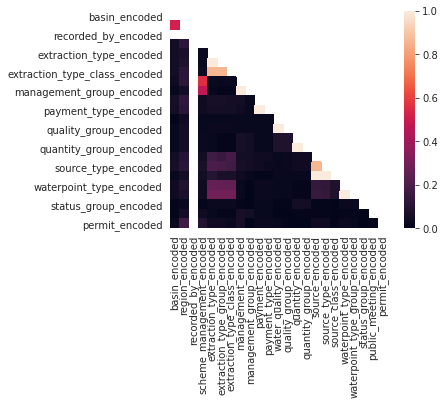

In [151]:
mask = np.zeros_like(df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

with sb.axes_style("white"):
  ax = sb.heatmap(df, mask=mask,vmin=0., vmax=1, square=True)

plt.show()

Interpreation of above:

Again some correlations between mostly geographic vars

Tho can remove source_type_encoded, source_class_encoded, extraction_type_group_encoded and management_group_encoded as these are clearly redundant

Nothing correlates strongly with status_group_encoded, the outcome var

In [152]:
wt.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,quantity_encoded,quantity_group_encoded,source_encoded,source_type_encoded,source_class_encoded,waterpoint_type_encoded,waterpoint_type_group_encoded,status_group_encoded,public_meeting_encoded,permit_encoded
0,69572,3.799832,2011-03-14,Roman,1.041377,Roman,-0.081164,-1.408734,none,NaN,...,1,1,8,7,0,1,1,0,1,0
1,8776,NaN,2013-03-06,Grumeti,1.054363,GRUMETI,-0.172951,1.207935,Zahanati,NaN,...,2,2,5,4,1,1,1,0,1,1
2,34310,-0.532695,2013-02-25,Lottery Club,0.025591,World vision,0.886294,0.639765,Kwa Mahundi,NaN,...,1,1,0,1,1,2,1,0,1,1
3,67743,NaN,2013-01-28,Unicef,-0.584746,UNICEF,1.279593,-1.849654,Zahanati Ya Nanyumbu,NaN,...,0,0,3,0,0,2,1,2,1,1
4,19728,NaN,2011-07-13,Action In A,-0.964223,Artisan,-1.541321,1.317270,Shuleni,NaN,...,3,3,5,4,1,1,1,0,1,1


In [154]:
wt.recorded_by_encoded.value_counts() # This is suboptimal

0    59402
Name: recorded_by_encoded, dtype: int64

In [ ]:
wt = wt.drop(columns=['source_type_encoded', 'source_class_encoded', 'extraction_type_group_encoded', 
                 'management_group_encoded'])

In [155]:
wt.shape

(59402, 64)

In [156]:
wt.dropna().shape # not going to drop NAs in this case ;)

(95, 64)

In [162]:
# Remove original version of cat vars that have been encoded
wt = wt.drop(columns=[x.replace('_encoded', '') for x in wt.columns if '_encoded' in x])

In [175]:
wt.shape

(59399, 40)

In [164]:
len(wt.funder.unique())

1898

In [165]:
len(wt.wpt_name.unique())

37400

In [166]:
wt = wt.drop(columns=['wpt_name'])

In [170]:
wt.status_group_encoded.value_counts()

 0    32260
 2    22823
 1     4316
-1        2
 3        1
Name: status_group_encoded, dtype: int64

In [174]:
# Remove any line without a value outcome var
wt['status_group_encoded'] = wt.status_group_encoded.replace(-1, np.nan)
wt['status_group_encoded'] = wt.status_group_encoded.replace(3, np.nan)
wt = wt.dropna(subset=['status_group_encoded'])
wt['status_group_encoded'] = wt['status_group_encoded'].astype(int)

/home/ian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [176]:
wt.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'num_private', 'subvillage',
       'region_code', 'district_code', 'lga', 'ward', 'population',
       'scheme_name', 'construction_year', 'basin_encoded', 'region_encoded',
       'recorded_by_encoded', 'scheme_management_encoded',
       'extraction_type_encoded', 'extraction_type_group_encoded',
       'extraction_type_class_encoded', 'management_encoded',
       'management_group_encoded', 'payment_encoded', 'payment_type_encoded',
       'water_quality_encoded', 'quality_group_encoded', 'quantity_encoded',
       'quantity_group_encoded', 'source_encoded', 'source_type_encoded',
       'source_class_encoded', 'waterpoint_type_encoded',
       'waterpoint_type_group_encoded', 'status_group_encoded',
       'public_meeting_encoded', 'permit_encoded'],
      dtype='object')

In [177]:
wt[numerics + categorics].to_csv("wt_for_ml.csv", index=False)